In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import re
import nltk
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [247]:
df = pd.read_csv('training.en.csv')


In [248]:
def preprocess_data(df, normalize =False): 
#to extract features from the text we would be using TfidfVectorizer. It convert a collection of raw documents to a matrix of TF-IDF features.
# we are not using bag of words or word2doc methods since information about order of words get lost in them. 

#We are filtering stop words and converting words into lowercase letters by passing appropriate arguments.

    X, Y = df['expression'], df['Intent']
    print(X.shape, Y.shape)
    #there are 6327 rows of data.
    
    tv = TfidfVectorizer( stop_words='english', max_features=100000, lowercase = True)
    X_tvidf = tv.fit_transform(X)

    #we use train test split to divide the data set into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X_tvidf, Y, test_size=0.3, random_state = 2)
    if(normalize):
        #SMOTE is an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.
        smt = SMOTE(random_state=777, k_neighbors=1)
        X_SMOTE, y_sampled = smt.fit_sample(X_train, y_train)
        return X_SMOTE, y_sampled, X_test, y_test
    else:
        return X_train, X_test, y_train, y_test

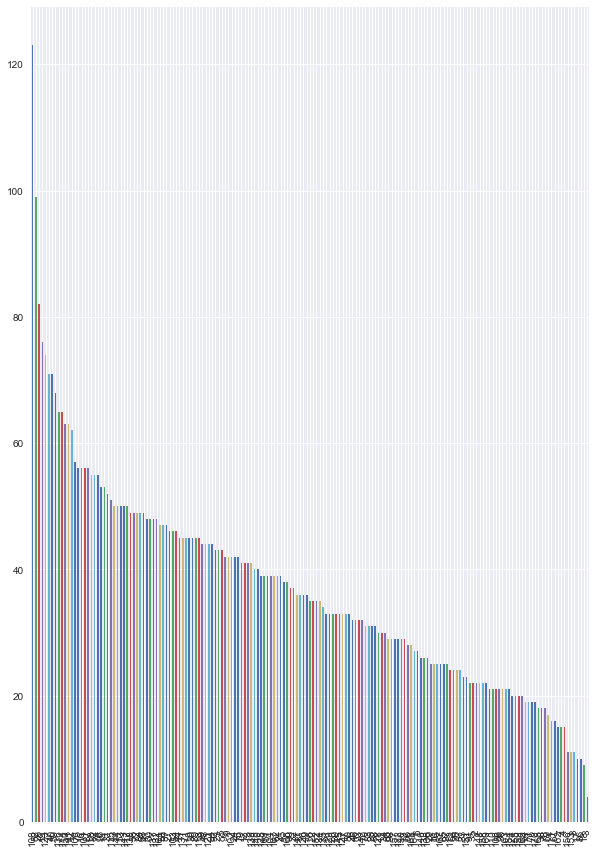

In [249]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 15)
df.Intent.value_counts().plot(kind='bar')
plt.show()


#we can see from the plot below that we have imbalanced data set i.e. no. of classes in the data set are not uniform.
#since our dataset is not very large, we will use over sampling method to make the dataset balanced.

In [250]:
X_SMOTE, y_sampled, X_test, y_test = preprocess_data(df, normalize =True)

(6327,) (6327,)


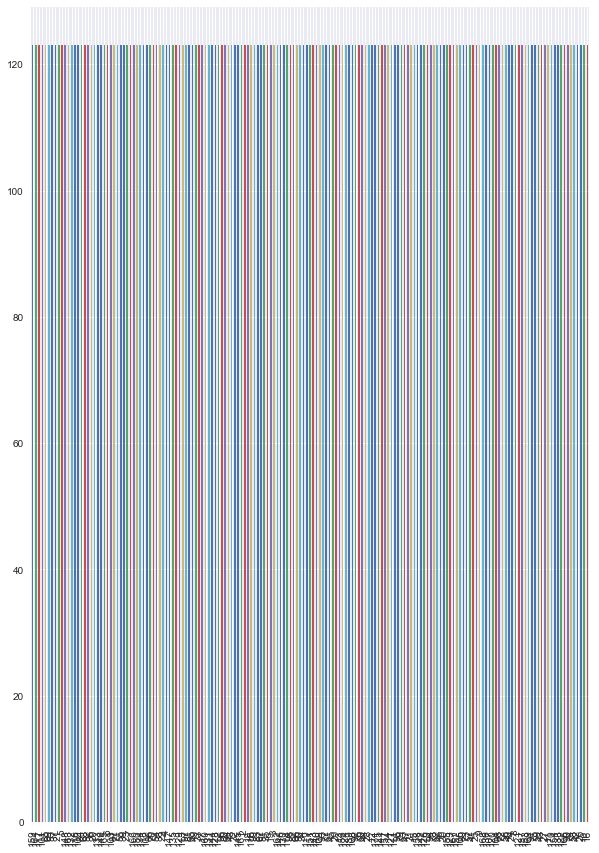

In [251]:
#from the plot below, we can now observe that all the classes have equal no. of observations. Hence the data is now balanced.
X_sampled = pd.DataFrame(X_SMOTE.todense(), columns=tv.get_feature_names())
pd.DataFrame(y_SMOTE)[0].value_counts().plot(kind='bar')



In [252]:
#we will now apply different classification algorithms and use f1 score as evaluation metric to find the best classification algorithm.

C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


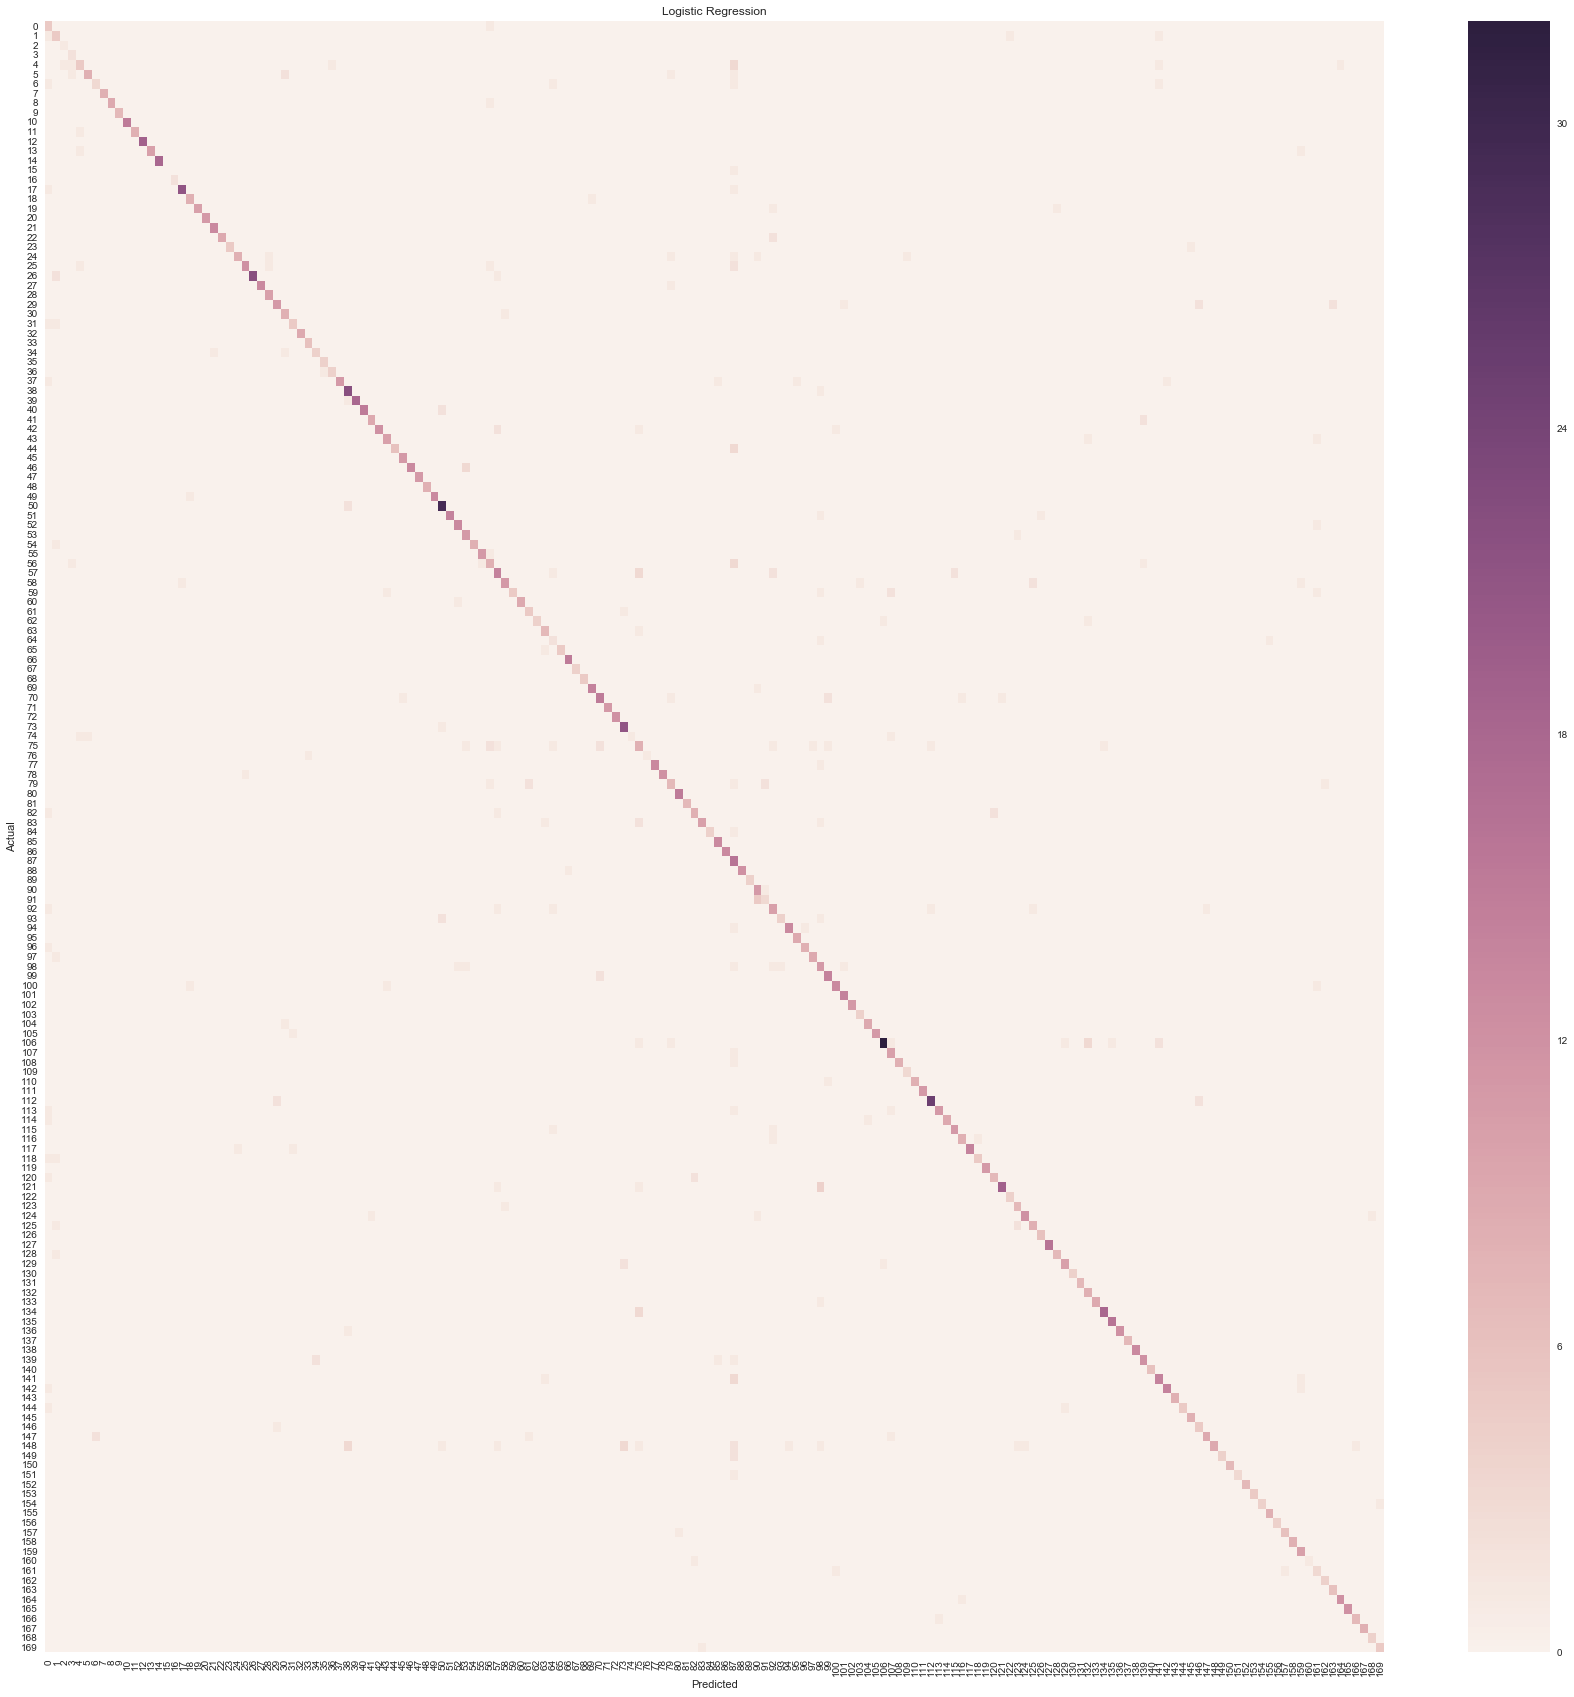

In [253]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class= 'multinomial', n_jobs = -1, solver='newton-cg')
logreg.fit(X_sampled, y_sampled)
y_pred = logreg.predict(X_test)

#Confusion matrix
conf_mat_logreg = pd.DataFrame(confusion_matrix(y_test, y_pred))
conf_mat_logreg

f1_score(y_test, y_pred, average='weighted')
f1_scores = []
f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

#heatmap
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(conf_mat_logreg, annot=False, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression')
plt.show()

C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


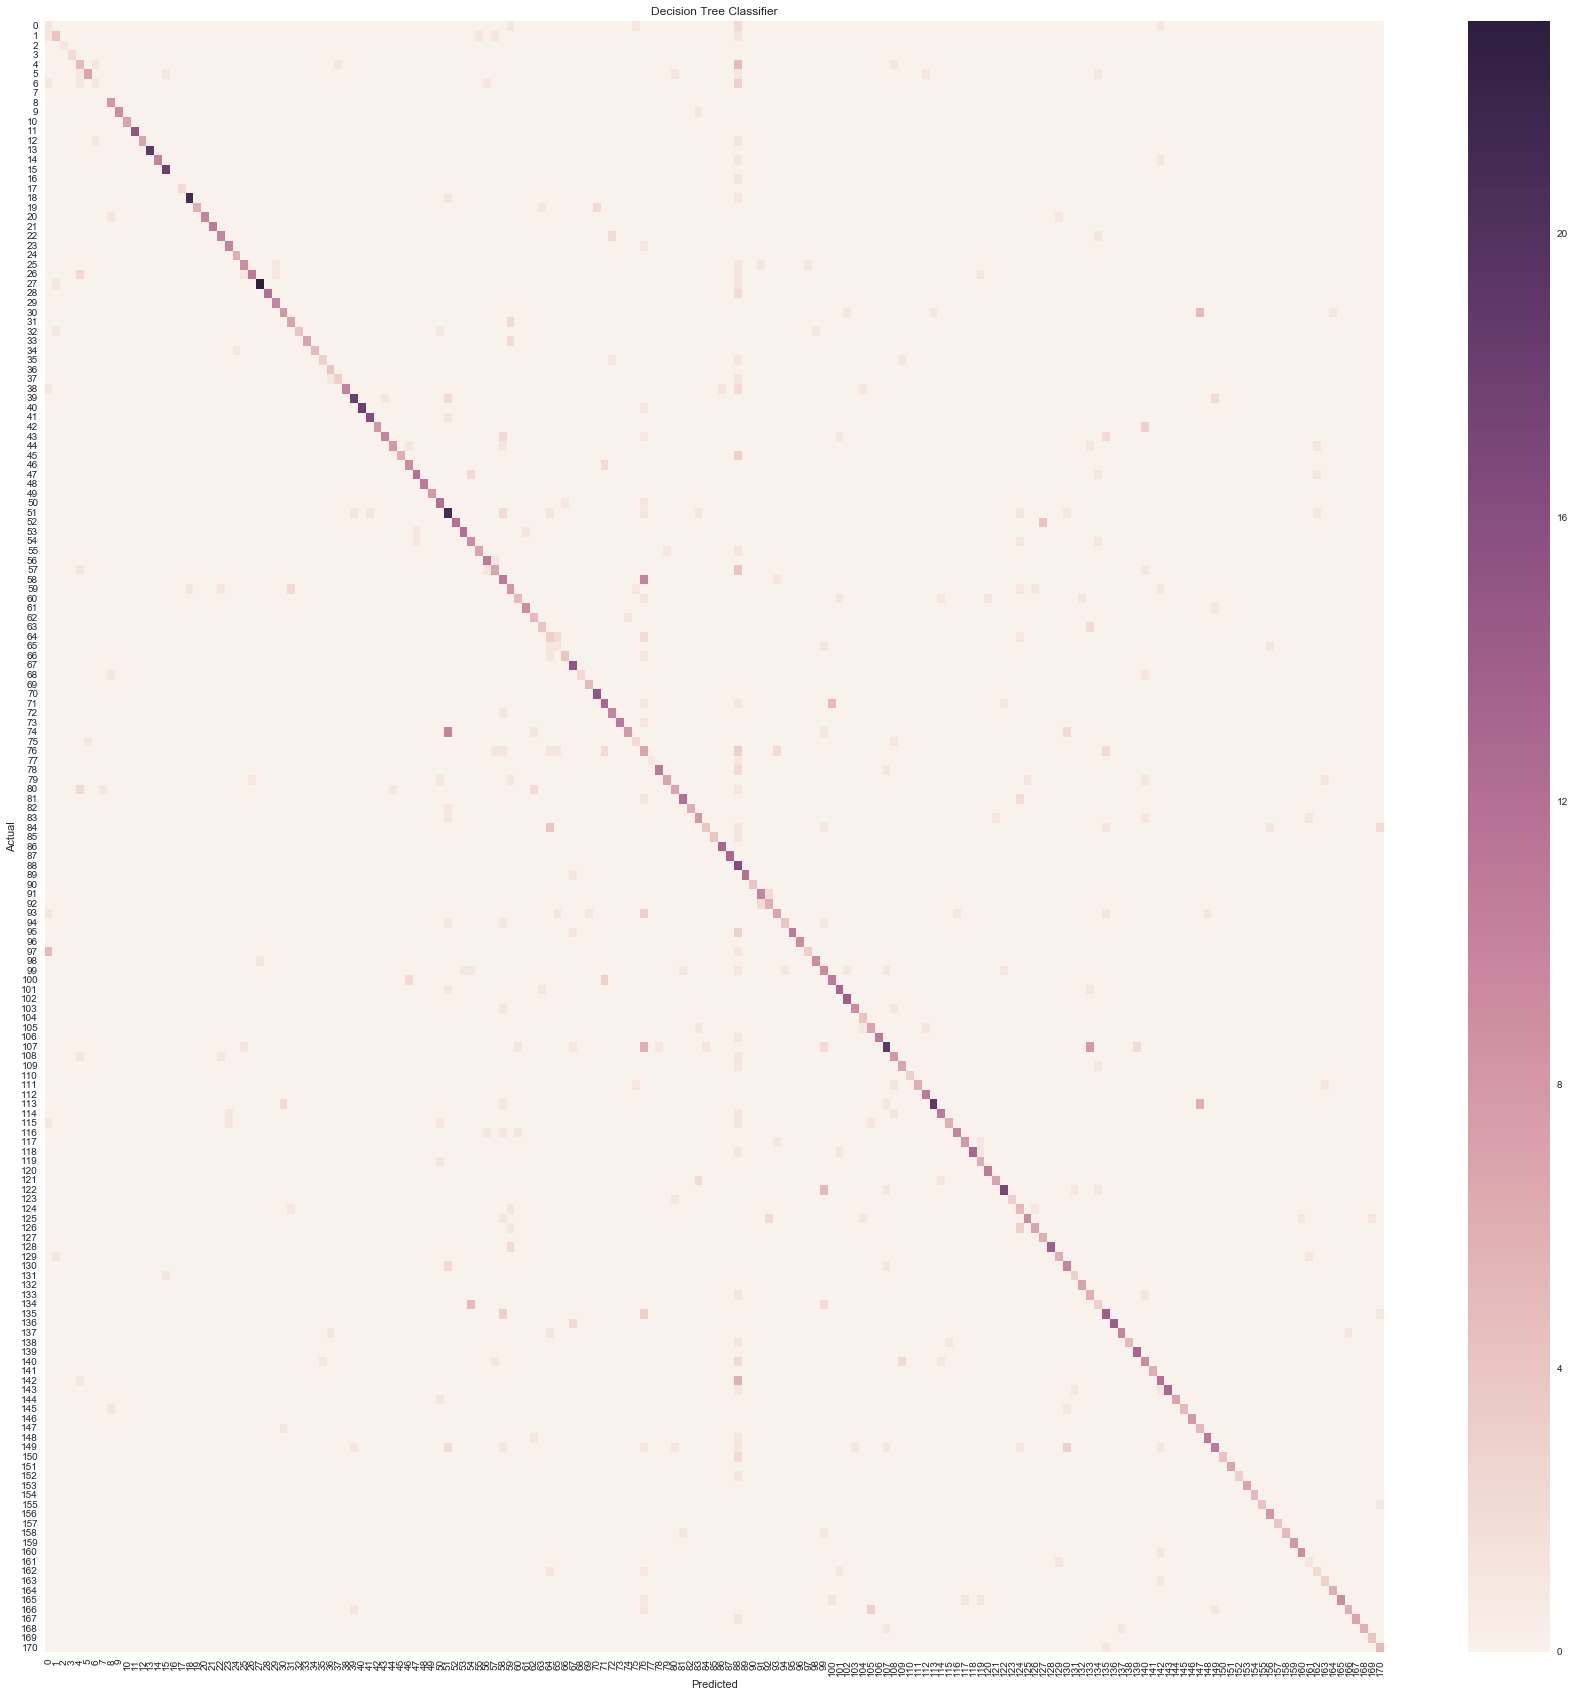

In [254]:
#Decision tree classifier
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier().fit(X_sampled, y_sampled) 
y_pred_dt = dtree_model.predict(X_test) 

f1_scores.append(f1_score(y_test, y_pred_dt, average='weighted'))

#confusion matrix
cnf_dt = confusion_matrix(y_test, y_pred_dt)

#heat map
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cnf_dt, annot=False, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Decision Tree Classifier')
plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 24.3min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 29.1min finished
C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 'sqrt', 'n_estimators': 500}


C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


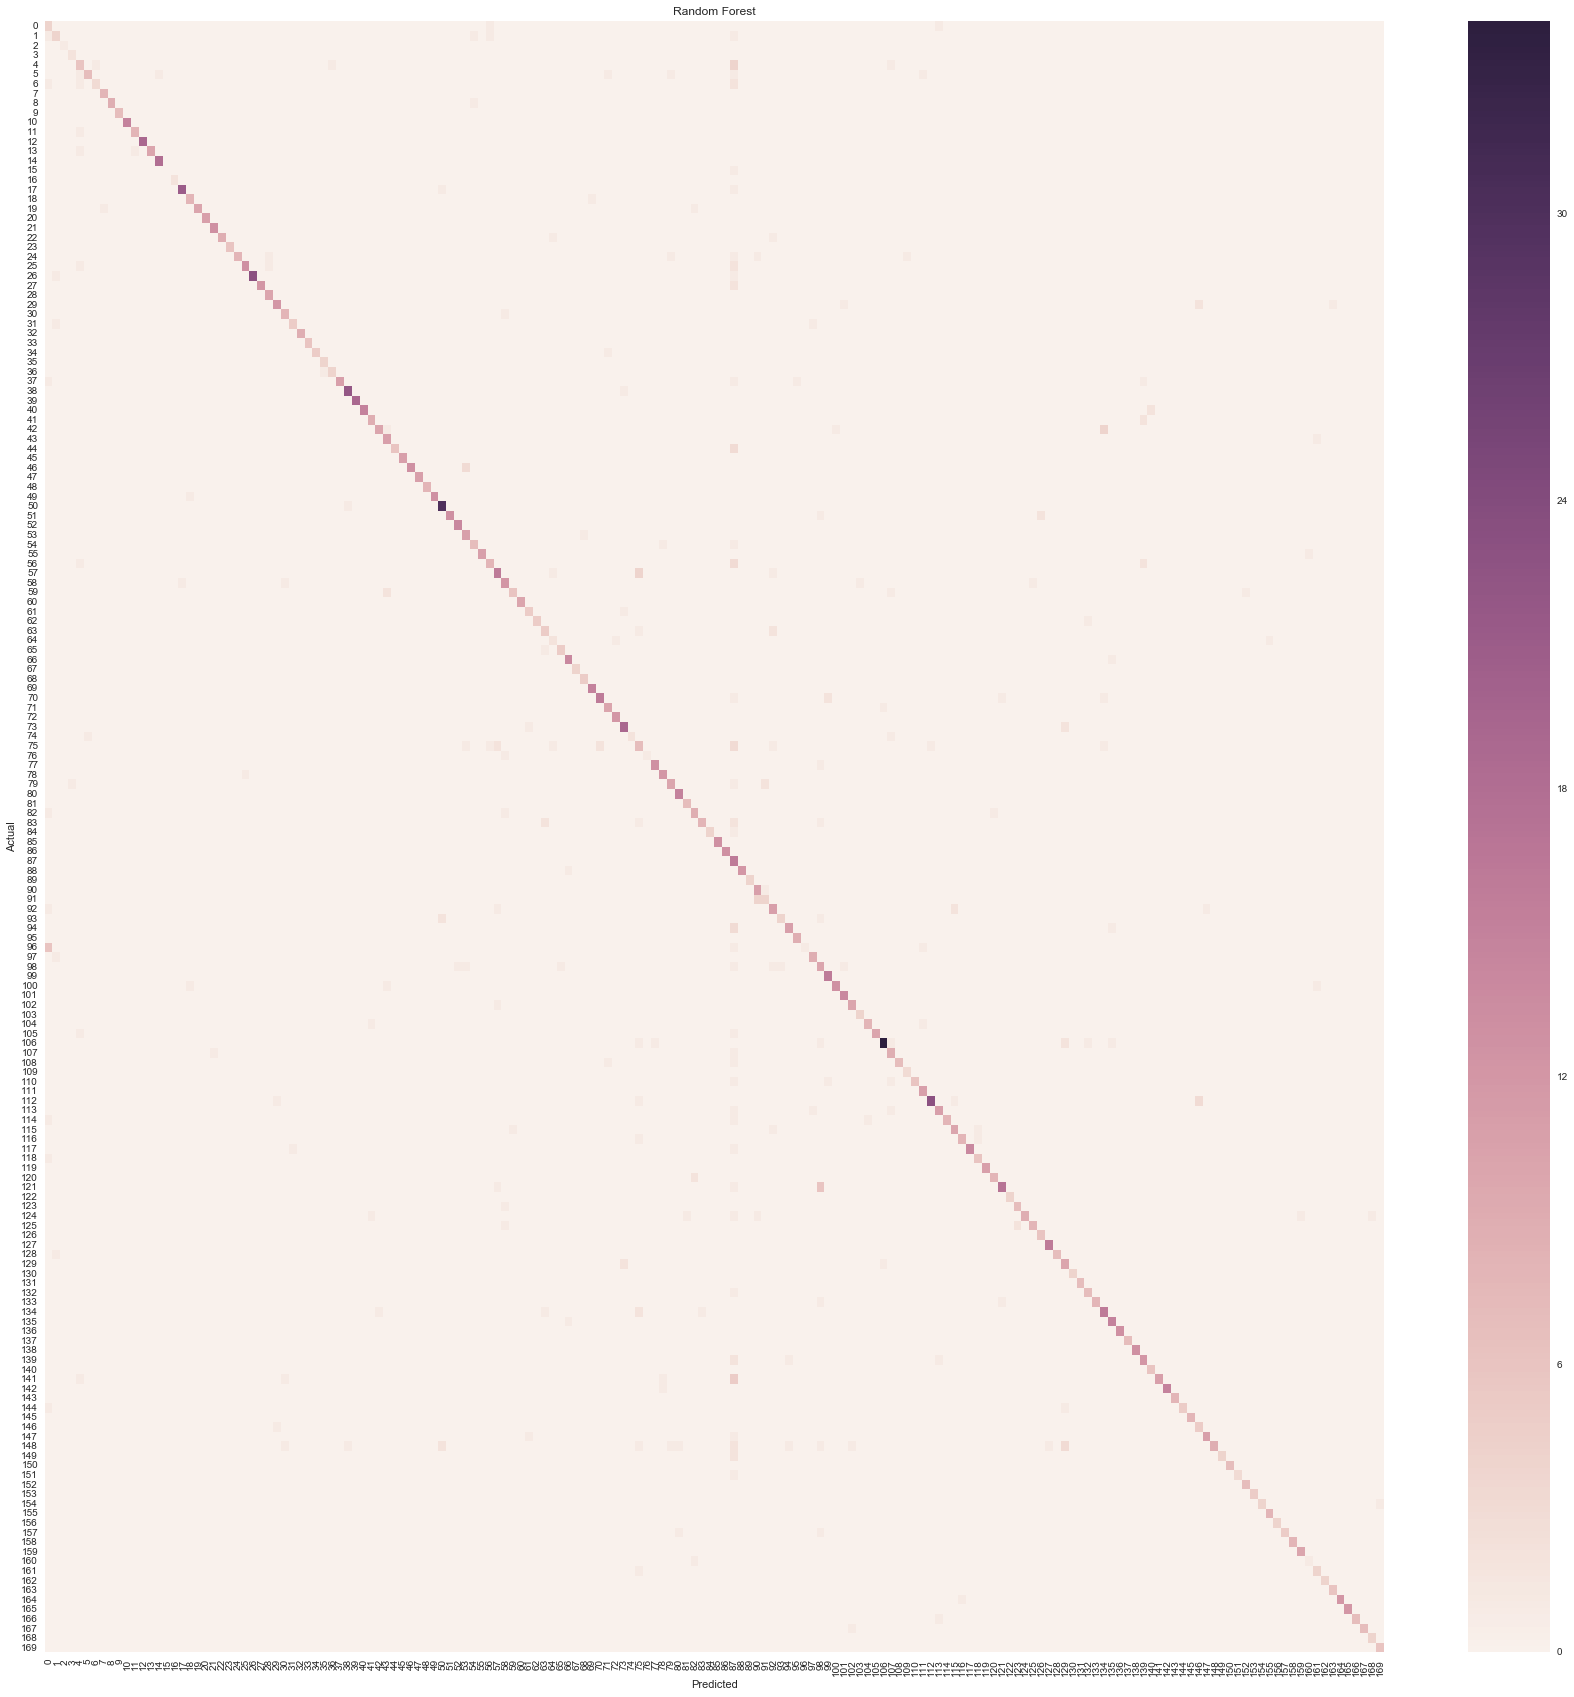

In [255]:
#Random Forest Classifier with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt']
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, verbose = 10 , scoring = 'f1_weighted', n_jobs=-1)
CV_rfc.fit(X_sampled, y_sampled)
print(CV_rfc.best_params_)
#{'max_features': 'sqrt', 'n_estimators': 500}

y_pred_rfc = CV_rfc.predict(X_test)
f1_scores.append(f1_score(y_test, y_pred_rfc, average='weighted'))

#confusion matrix
cnf_rfc = confusion_matrix(y_test, y_pred_rfc)
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cnf_rfc, annot=False, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest')
plt.show()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8471396764776987, total=   2.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8589722800058386, total=   1.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8907392283124289, total=   1.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8988524869679787, total=   1.9s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ravi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


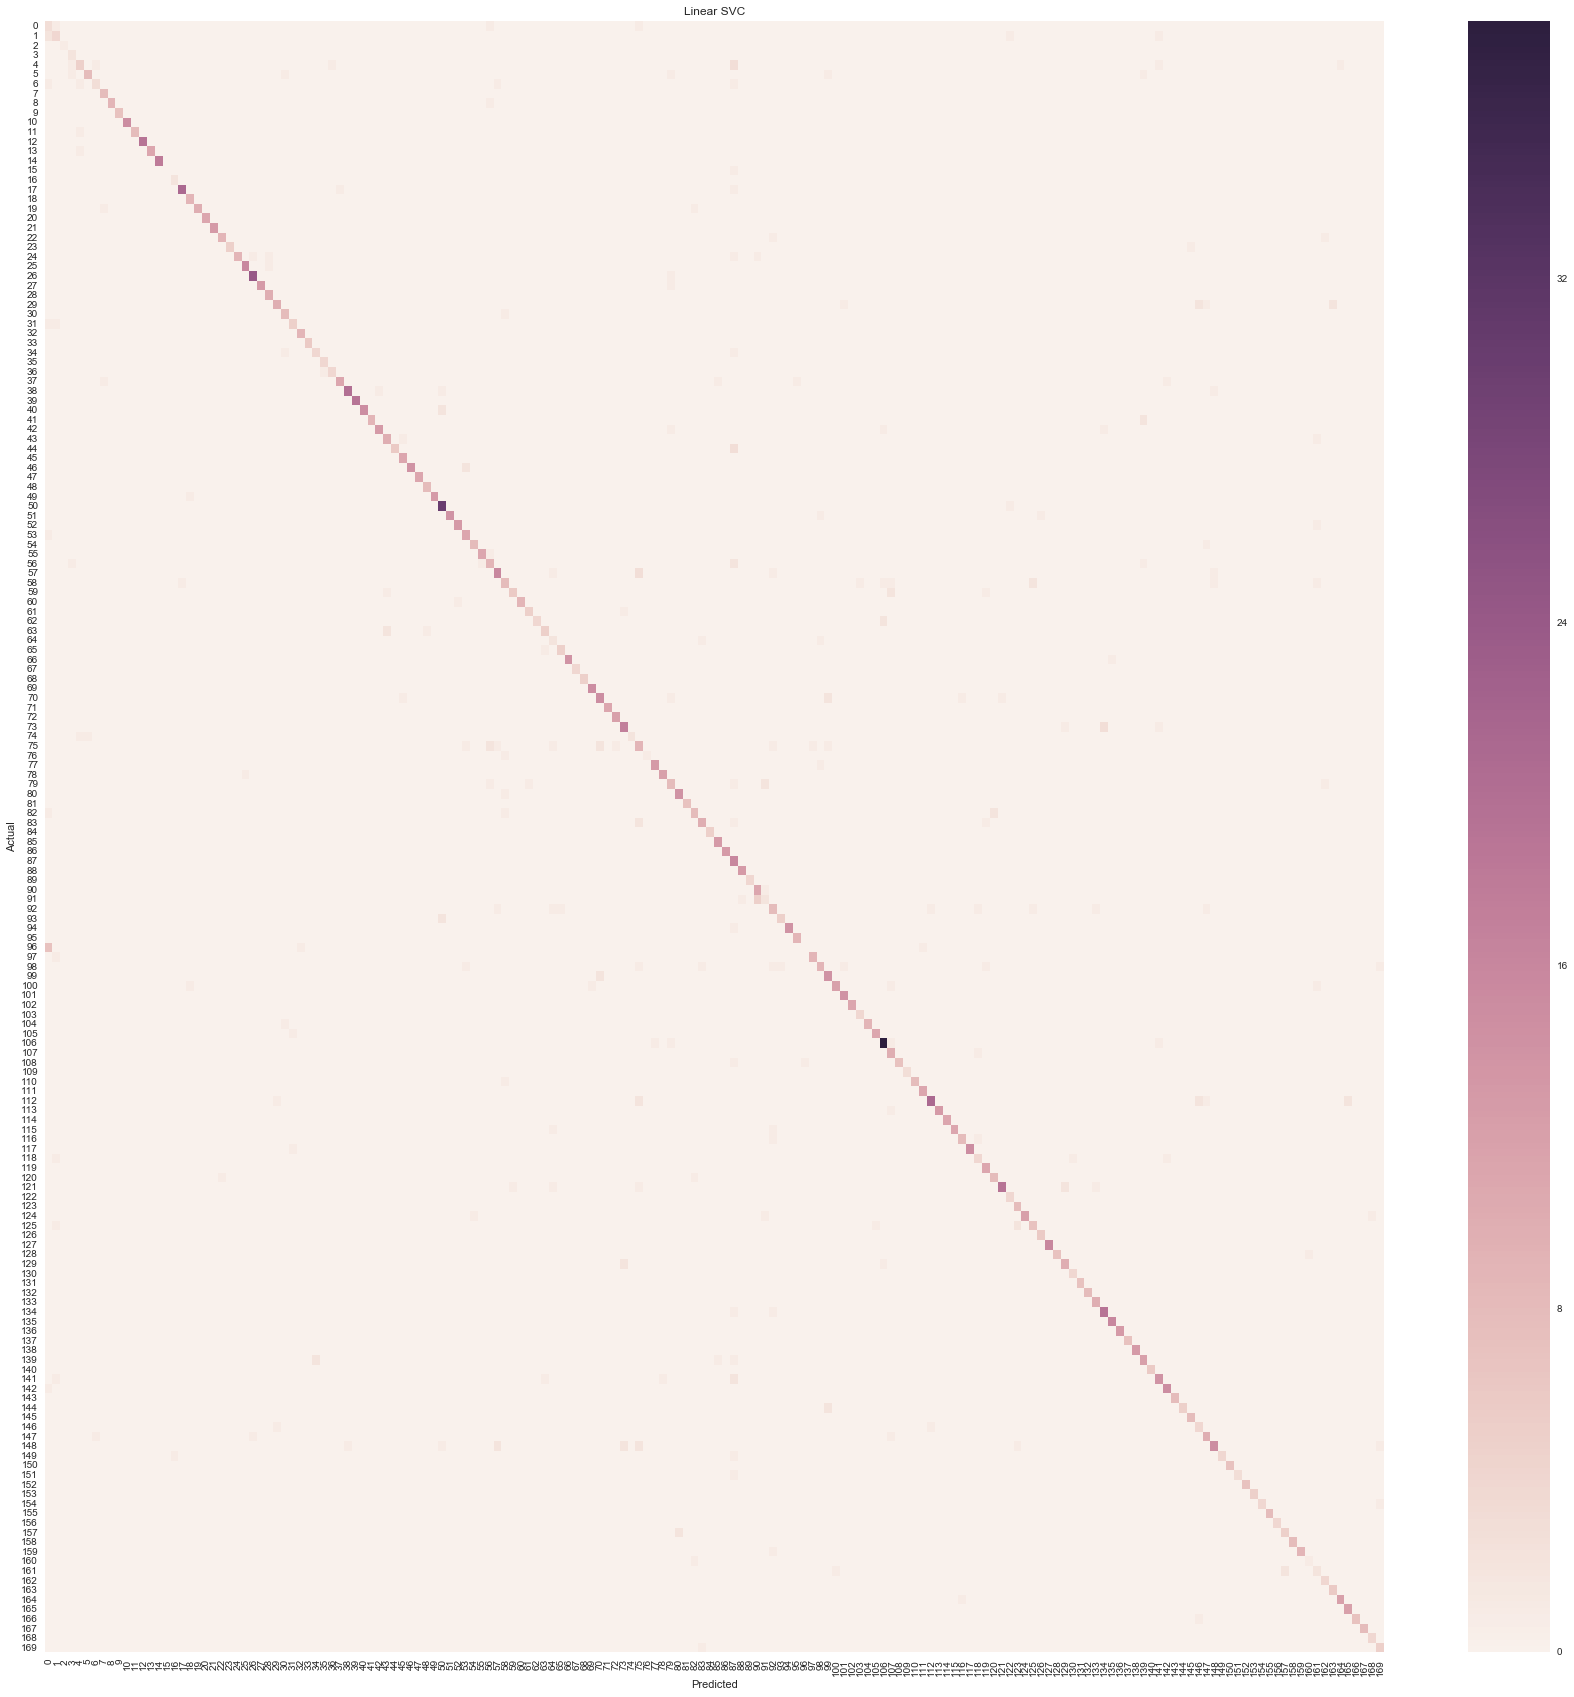

In [256]:
#LinearSVC Classifier
from sklearn.svm import LinearSVC

svc_lin = LinearSVC()
param_grid = {'C':[0.01, 0.1, 1 ]}

grid_svc_lin = GridSearchCV(svc_lin, param_grid, cv = 5, scoring='f1_weighted', verbose = 100)
grid_svc_lin.fit(X_sampled, y_sampled)
grid_svc_lin.best_params_
#{'C': 1}

y_pred_svc = grid_svc_lin.predict(X_test)
f1_scores.append(f1_score(y_test, y_pred_svc, average='weighted'))

cnf_svc = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cnf_svc, annot=False, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Linear SVC')
plt.show()



In [257]:
#On Comparing results from different classification models, we get similar f1 scores for Logistic Regression (0.847), Random Forest (0.8393) and Linear SVC(0.8478).
f1_scores

[0.8476945859996459,
 0.7565995697032112,
 0.8416477048369637,
 0.8478544842713376]

In [258]:
#use following lines of code for validation data set
#df1 = pd.read_csv('path to validation file')

#check if the data is normalized. If not normalized then set normalize = True in preprocess method else set normalize = False
#X_SMOTE, y_sampled, X_test, y_test = preprocess_data(df, normalize =True)
#X_sampled = pd.DataFrame(X_SMOTE.todense(), columns=tv.get_feature_names())

#we will use logistic regression to sole multiclassification problem.
#Logistic Regression
#from sklearn.linear_model import LogisticRegression

#logreg = LogisticRegression(multi_class= 'multinomial', n_jobs = -1, solver='newton-cg')
#logreg.fit(X_sampled, y_sampled)
#y_pred = logreg.predict(X_test)

#Confusion matrix
#conf_mat_logreg = pd.DataFrame(confusion_matrix(y_test, y_pred))
#conf_mat_logreg

#check the F1 score of validation dataset
#f1_score(y_test, y_pred, average='weighted')